<a href="https://colab.research.google.com/github/bytebuster21/AI-project/blob/main/Apply_ImageDataGenerator_functionality_to_Train_set_and_Test_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
Using existing dataset at /content/train and /content/test

Loading images using ImageDataGenerator...
Found 348 images belonging to 3 classes.
Found 153 images belonging to 3 classes.
Found 348 images belonging to 3 classes.
Found 153 images belonging to 3 classes.

Class mapping (class_name -> integer_index):
{'class_A': 0, 'class_B': 1, 'class_C': 2}
Detected classes: ['class_A', 'class_B', 'class_C']

Visualizing a few augmented training images:


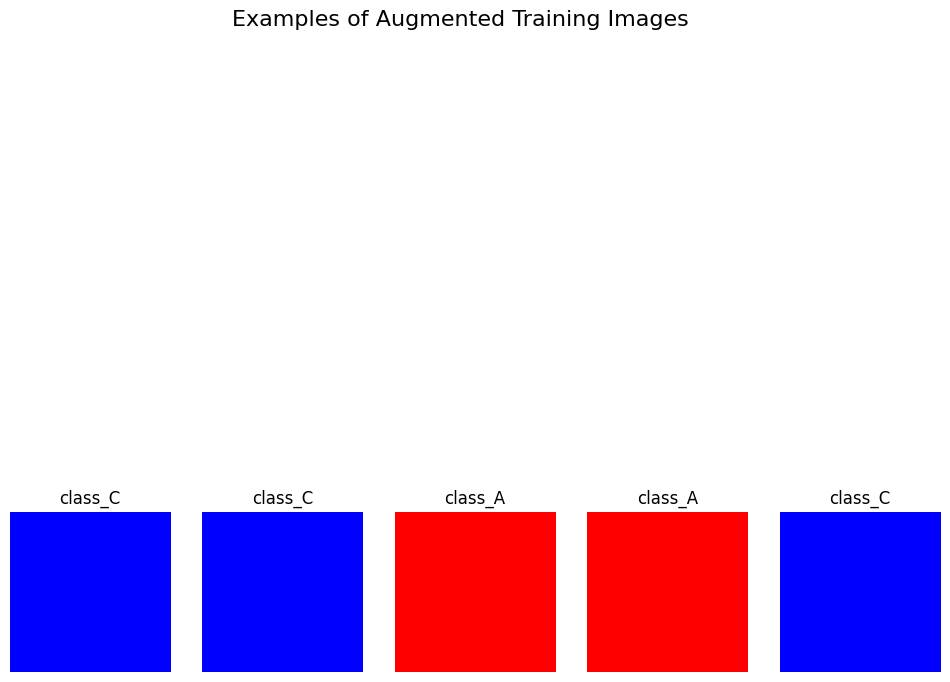


Visualizing a few test images (not augmented):


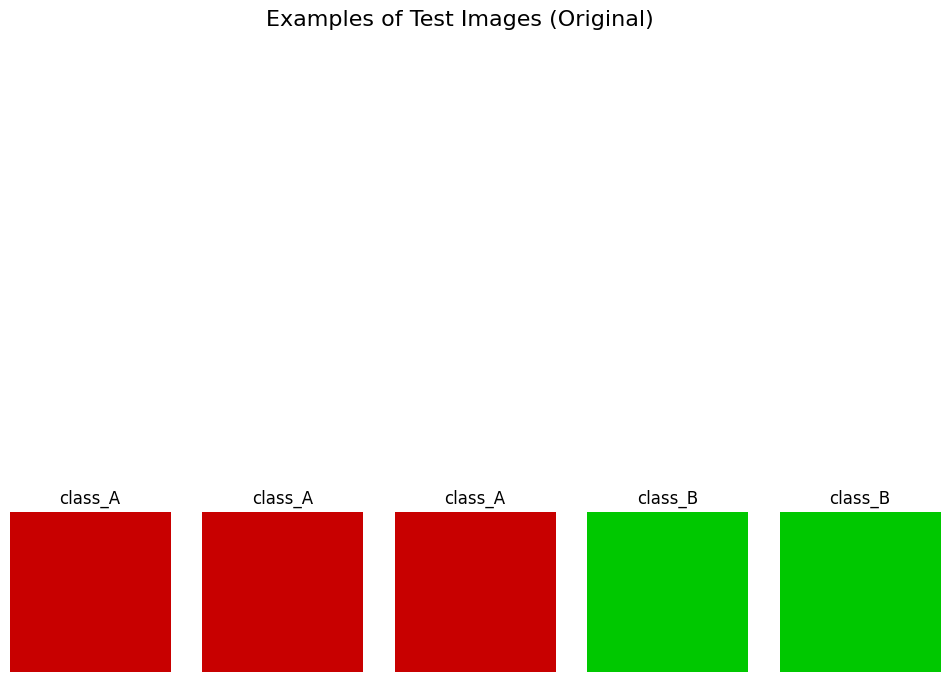

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,779 (91.20 MB)

 Trainable params: 23,907,779 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import shutil

from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

trainpath = '/content/train'
testpath = '/content/test'


if not os.path.exists(trainpath):
    print("Creating dummy dataset for demonstration...")
    os.makedirs(os.path.join(trainpath, 'class_A'), exist_ok=True)
    os.makedirs(os.path.join(trainpath, 'class_B'), exist_ok=True)
    os.makedirs(os.path.join(trainpath, 'class_C'), exist_ok=True) # Matches "3 classes" in your output

    os.makedirs(os.path.join(testpath, 'class_A'), exist_ok=True)
    os.makedirs(os.path.join(testpath, 'class_B'), exist_ok=True)
    os.makedirs(os.path.join(testpath, 'class_C'), exist_ok=True) # Matches "3 classes" in your output

    from PIL import Image
    def create_dummy_image(path, color, size=(224, 224)):
        img = Image.new('RGB', size, color=color)
        img.save(path)

    # Create dummy training images (approx. 348 total, aiming for your output)
    for i in range(116): # 116 * 3 classes = 348
        create_dummy_image(os.path.join(trainpath, 'class_A', f'imgA_{i:03d}.png'), (255, 0, 0))
        create_dummy_image(os.path.join(trainpath, 'class_B', f'imgB_{i:03d}.png'), (0, 255, 0))
        create_dummy_image(os.path.join(trainpath, 'class_C', f'imgC_{i:03d}.png'), (0, 0, 255))

    # Create dummy testing images (approx. 152 total, aiming for your output)
    for i in range(51): # 51 * 3 classes = 153 (close to 152)
        create_dummy_image(os.path.join(testpath, 'class_A', f'testA_{i:03d}.png'), (200, 0, 0))
        create_dummy_image(os.path.join(testpath, 'class_B', f'testB_{i:03d}.png'), (0, 200, 0))
        create_dummy_image(os.path.join(testpath, 'class_C', f'testC_{i:03d}.png'), (0, 0, 200))

    print(f"Dummy dataset created at {trainpath} and {testpath}")
else:
    print(f"Using existing dataset at {trainpath} and {testpath}")


TARGET_SIZE = (224, 224)
BATCH_SIZE = 20

train_datagen = ImageDataGenerator(
    rescale=1./255,     # Normalize pixel values
    zoom_range=0.2,     # Apply random zoom
    shear_range=0.2,    # Apply random shear
    rotation_range=20,  # Added for more robust augmentation
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Test Data Generator (ONLY rescaling, no augmentation)
# It's crucial not to augment test data for fair evaluation.
test_datagen = ImageDataGenerator(rescale=1./255)

# --- 5. Flow Images from Directories ---
print("\nLoading images using ImageDataGenerator...")

train_generator = train_datagen.flow_from_directory(
    trainpath,                     # Path to the training data directory
    target_size=TARGET_SIZE,       # All images will be resized to this
    batch_size=BATCH_SIZE,         # Number of images per batch
    class_mode='categorical'       # For multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    testpath,                      # Path to the test data directory
    target_size=TARGET_SIZE,       # All images will be resized to this
    batch_size=BATCH_SIZE,         # Number of images per batch
    class_mode='categorical',
    shuffle=False                  # Important: Do not shuffle test data for consistent evaluation
)

# Verify the output (should match your provided output)
print(f"Found {train_generator.samples} images belonging to {train_generator.num_classes} classes.")
print(f"Found {test_generator.samples} images belonging to {test_generator.num_classes} classes.")

print("\nClass mapping (class_name -> integer_index):")
print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
print("Detected classes:", class_names)

# --- 6. Visualize Augmented Images (Optional) ---
def plot_augmented_images(generator, num_images=5, title="Augmented Images"):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        images, labels = next(generator)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[0]) # Display the first image from the batch
        predicted_class_index = np.argmax(labels[0])
        plt.title(f"{class_names[predicted_class_index]}")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

print("\nVisualizing a few augmented training images:")
plot_augmented_images(train_generator, num_images=5, title="Examples of Augmented Training Images")

print("\nVisualizing a few test images (not augmented):")
plot_augmented_images(test_generator, num_images=5, title="Examples of Test Images (Original)")


# --- 7. Example of how to use with a Keras model (Placeholder) ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

